# 今回の取り組み

## Nanoporeに最後まで読まれなかった（途中で切断された）リードがクラスタに分かれてしまうので、これを除去したい

- これはControlにも存在するはずだが、現状ではクラスラリングの際にControlにおいて切断リードの大半が含まれるであろうSVを無視しているため、差分が効いていない

- ✅ (1) SV判定をコンセンサスコールのあとにずらす
- **(2) クラスタリングの際にSampleとControlに同様に見られる切断リードを除く**

**前回は`replace_NtoD`の改善で長くなってしまったので、今回は改めてClusteringに集中します**


## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report

#### #* 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/tyr_albino_50%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "single_tyr_50",
    "mm10",
    True,
    14,
)
print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single_tyr_50...


In [6]:

flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

flag = False
if not flag:
    print("preprocessing...")
    ################################################################################
    # Export fasta files as single-FASTA format
    ################################################################################
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    ###############################################################################
    # Mapping with mappy
    ###############################################################################
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    ########################################################################
    # MIDSV conversion
    ########################################################################
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    ###############################################################################
    # CSSPLITS Error Correction
    ###############################################################################
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    ###############################################################################
    # Convert any `N` as deletions other than consecutive `N` from both ends
    ###############################################################################
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    ###############################################################################
    # Cashe inputs (control)
    ###############################################################################
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


preprocessing...


In [7]:
%%bash
# 確認
cat DAJINResults/.tempdir/single_tyr_50/midsv/tyr_albino_50%_splice_control.jsonl | grep "3d5bc6ea9b40"

{"QNAME": "03f31ef7-f592-4a0b-9840-3d5bc6ea9b40", "RNAME": "control", "CSSPLIT": "=T,=G,=C,=A,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,

- `N`が配列長の半分を超えている場合にも、欠失となるバグは修正されました!

In [9]:
####################################################################################
# Classify alleles
####################################################################################
print("Classify...")

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

# for classif in classif_sample:
#     classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)

####################################################################################
# Clustering
####################################################################################
print("Clustering...")

MUTATION_LOCI = clustering.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)


Classify...
Clustering...


In [11]:
print(MUTATION_LOCI)

defaultdict(<class 'dict'>, {'control': {135: 'ins', 828: 'sub', 1142: 'ins'}})


In [10]:
clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)

TypeError: 'NoneType' object is not iterable

In [12]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from pathlib import Path

import midsv

from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels
from DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci


def _compress_insertion(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


def _extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if i in mutation_loci:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


def _annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            if mutscore == {}:
                score.append(0)
                continue
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores


def _reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS: int = 1) -> list[dict[str]]:
    knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: dict[int, str] = MUTATION_LOCI[allele]
        if mutation_loci == {}:
            labels_all.extend([1] * len(classif_sample))
            continue
        knockin_loci: set = knockin_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        cssplits_control = _compress_insertion(cssplits_control)
        cssplits_sample = _compress_insertion(cssplits_sample)
        cssplits_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
        cssplits_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
        mutation_score = make_score(cssplits_control, cssplits_sample)
        scores_control = _annotate_score(cssplits_control, mutation_score)
        scores_sample = _annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = _reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = clust_sample.copy()
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [14]:
import midsv
allele = "control"
mutation_loci = MUTATION_LOCI[allele]
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

cssplits_control = _compress_insertion(cssplits_control)
cssplits_sample = _compress_insertion(cssplits_sample)
cssplits_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
cssplits_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
mutation_score = make_score(cssplits_control, cssplits_sample)

In [18]:
print(len(cssplits_control))
print(len(cssplits_sample))
print(mutation_score)

10000
5000
None


In [19]:
from __future__ import annotations

from collections import Counter


def _call_count(cssplits: list[list[str]]) -> list[dict[str, int]]:
    count_kmer = []
    for cs in list(zip(*cssplits)):
        count_kmer.append(dict(Counter(cs)))
    return count_kmer


def _call_percent(counts: list[dict[str:int]]) -> list[dict[str:float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def _subtract_percentage(percent_control, percent_sample) -> list[dict]:
    sample_subtracted = []
    for cont, samp in zip(percent_control, percent_sample):
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


def _discard_common_error(percent_subtraction, threshold=0.5) -> list[dict]:
    percent_discarded = []
    for samp in percent_subtraction:
        remained = {k: v for k, v in samp.items() if v > threshold}
        percent_discarded.append(remained)
    return percent_discarded


def _discard_match(percent_discarded) -> list[dict]:
    mutation_score = []
    for samp in percent_discarded:
        if samp == {}:
            continue
        if "" in samp:
            continue
        if list(samp.keys())[0].split(",")[1].startswith("="):
            continue
        remained = {k: v for k, v in samp.items()}
        mutation_score.append(remained)


###############################################################################
# main
###############################################################################


def make_score(cssplits_control, cssplits_sample) -> list[dict[str, float]]:
    counts_control = _call_count(cssplits_control)
    counts_sample = _call_count(cssplits_sample)
    percent_control = _call_percent(counts_control)
    percent_sample = _call_percent(counts_sample)
    percent_subtraction = _subtract_percentage(percent_control, percent_sample)
    percent_discarded = _discard_common_error(percent_subtraction, 0.5)
    mutation_score = _discard_match(percent_discarded)
    return mutation_score


In [20]:
counts_control = _call_count(cssplits_control)
counts_sample = _call_count(cssplits_sample)
percent_control = _call_percent(counts_control)
percent_sample = _call_percent(counts_sample)
percent_subtraction = _subtract_percentage(percent_control, percent_sample)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)
mutation_score = _discard_match(percent_discarded)

None


In [40]:
def _discard_match(percent_discarded) -> list[dict]:
    mutation_score = []
    for samp in percent_discarded:
        if samp == {}:
            score = {}
        elif "" in samp:
            score = {}
        elif list(samp.keys())[0].split(",")[1].startswith("="):
            score = {}
        else:
            score = {k: v for k, v in samp.items()}
        mutation_score.append(score)
    return mutation_score


In [41]:
counts_control = _call_count(cssplits_control)
counts_sample = _call_count(cssplits_sample)
percent_control = _call_percent(counts_control)
percent_sample = _call_percent(counts_sample)
percent_subtraction = _subtract_percentage(percent_control, percent_sample)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)
mutation_score = _discard_match(percent_discarded)

In [43]:
print(mutation_score)

[{}, {'=C,*GT,=T': 49.48}, {'N,N,N': 0.6799999999999999}]


In [44]:
print(cssplits_sample[3])
print(counts_sample[2])
print(percent_sample[2])
print(percent_subtraction[2])
print(percent_discarded[2])


['=C,=T,=T', '=C,*GT,=T', '=C,=T,=A']
{'=C,=T,=A': 4794, '=C,+I=T,=A': 61, 'N,N,N': 91, '-C,-T,-A': 18, '=C,+I*TC,=A': 5, '+I=C,=T,=A': 15, '=C,=T,+I=A': 11, '+I=C,+I=T,=A': 2, '=c,=t,=a': 1, '=C,=T,+I*AT': 1, '=C,=T,+I*AC': 1}
{'=C,=T,=A': 95.88, '=C,+I=T,=A': 1.22, 'N,N,N': 1.82, '-C,-T,-A': 0.36, '=C,+I*TC,=A': 0.1, '+I=C,=T,=A': 0.3, '=C,=T,+I=A': 0.22, '+I=C,+I=T,=A': 0.04, '=c,=t,=a': 0.02, '=C,=T,+I*AT': 0.02, '=C,=T,+I*AC': 0.02}
{'=C,=T,=A': -1.1299999999999955, '=C,+I=T,=A': 0.47, 'N,N,N': 0.6799999999999999, '-C,-T,-A': -0.08999999999999997, '=C,+I*TC,=A': 0.020000000000000004, '+I=C,=T,=A': 0.09, '=C,=T,+I=A': 0.0, '+I=C,+I=T,=A': 0.03, '=c,=t,=a': 0.02, '=C,=T,+I*AT': 0.01, '=C,=T,+I*AC': -0.030000000000000002, '=C,N,N': -0.01, '-C,=T,+I=A': -0.01, '=C,+I=T,+I=A': -0.01, '+I*CT,=T,=A': -0.01, '=C,=T,+I*AG': -0.01, '=C,+I=T,+I*AC': -0.01, '+I=C,=T,+I=A': -0.01}
{'N,N,N': 0.6799999999999999}


- 'N,N,N'は評価対象としない

In [54]:
def _discard_match_and_n(percent_discarded) -> list[dict]:
    mutation_score = []
    for samp in percent_discarded:
        if samp == {} or "" in samp:
            mutation_score.append({})
            continue
        cs_center = list(samp.keys())[0].split(",")[1]
        if cs_center.startswith("=") or cs_center == ("N"):
            mutation_score.append({})
            continue
        score = {k: v for k, v in samp.items()}
        mutation_score.append(score)
    return mutation_score



In [55]:
counts_control = _call_count(cssplits_control)
counts_sample = _call_count(cssplits_sample)
percent_control = _call_percent(counts_control)
percent_sample = _call_percent(counts_sample)
percent_subtraction = _subtract_percentage(percent_control, percent_sample)
percent_discarded = _discard_common_error(percent_subtraction, 0.5)
mutation_score = _discard_match_and_n(percent_discarded)
print(mutation_score)

[{}, {'=C,*GT,=T': 49.48}, {}]


In [56]:
scores_control = _annotate_score(cssplits_control, mutation_score)
scores_sample = _annotate_score(cssplits_sample, mutation_score)
labels = return_labels(scores_sample, scores_control)

In [57]:
from collections import Counter
Counter(labels)

Counter({2: 2522, 1: 2478})

- 意図した通り、`mutation_score`から'N,N,N'のスコアがなくなりました
- Batchで動作確認をします

In [60]:
%%bash
rm -rf DAJINResults/batch_tyr_50_10_01 DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/batch_tyr_50_10_01 to see the report.

real	9m59.444s
user	8m49.080s
sys	2m15.376s


- いい感じに`SV`がなくなりました！

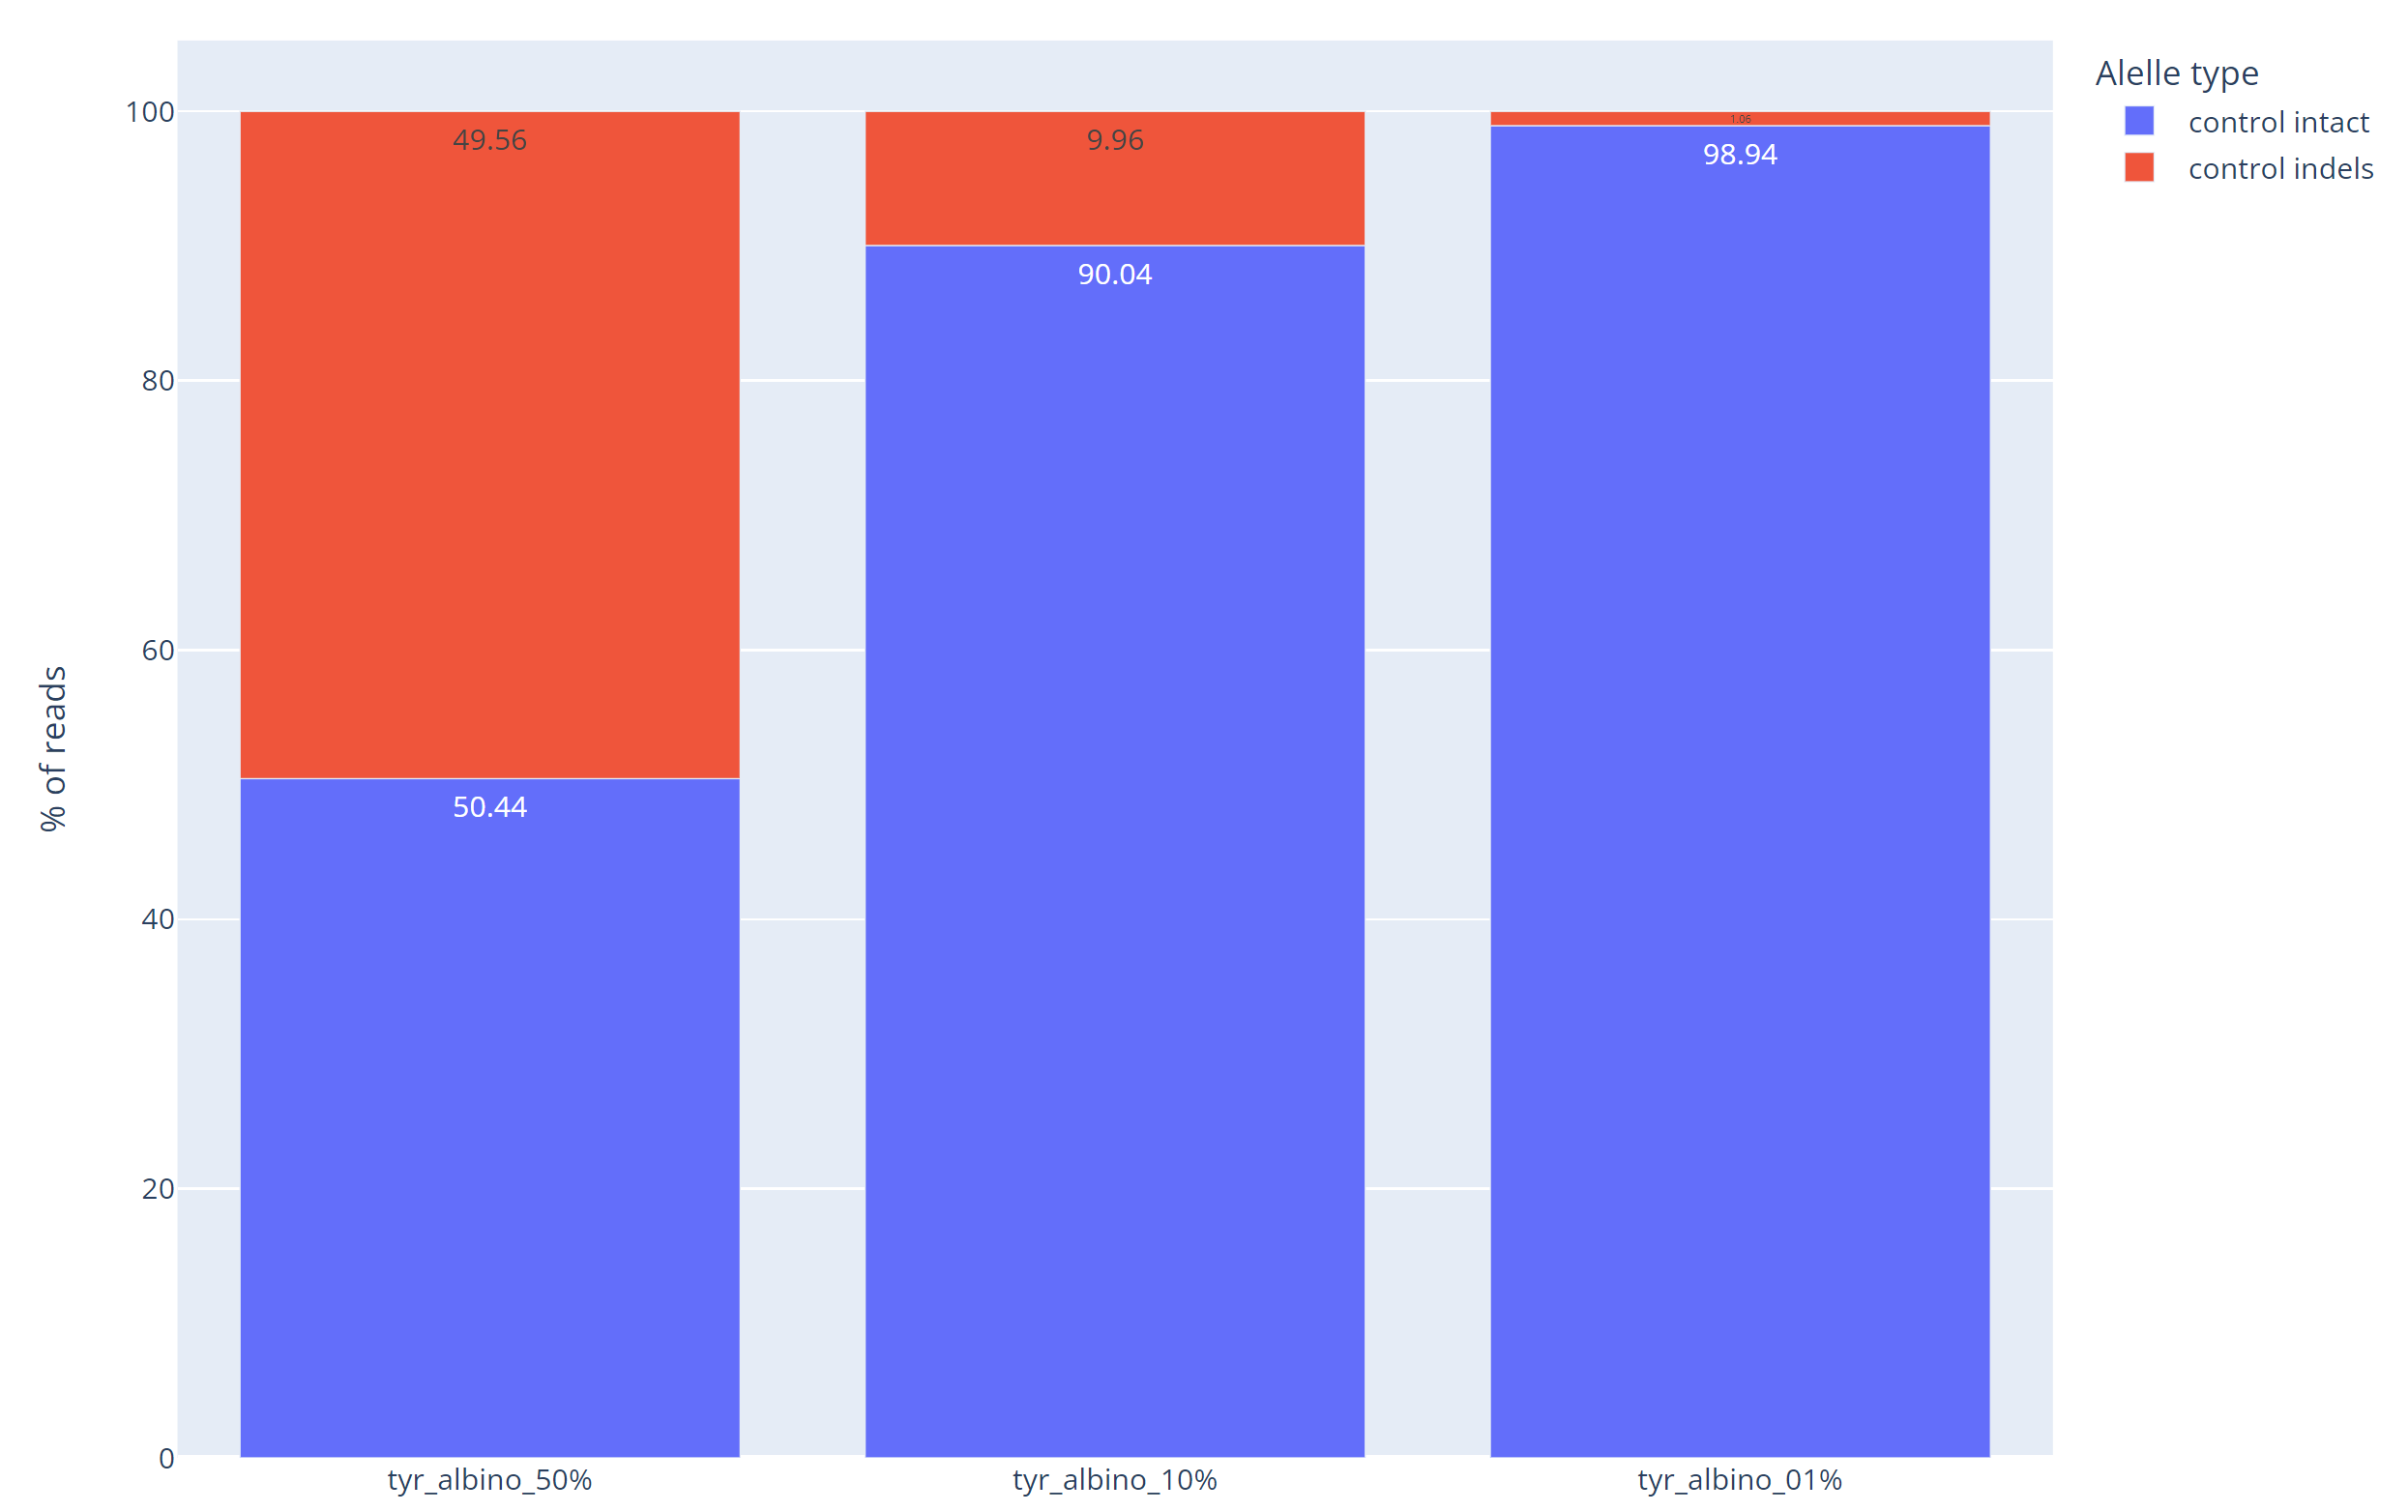

- 次に、ほかのサンプルでも適応できるのかを確認しましょう

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `clustering`の`make_score`を更新し、`N`に対してスコアを付与しない方針にしました
- **次に、ほかのサンプルでも適応できるのかを確認する必要があります**
- もしうまく行ったら、最後の砦？であるknock-in配列について進みます
    - VCFのほうが砦かもしれませんが

# 次に取り組むこと

### Lists

+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
> + ⬜ cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`clustering.replace_both_ends_n`）
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする